In [1]:
# Load in resources based on alpha setup
import os
from pathlib import Path
import pandas as pd
import dill
import numpy as np
import sys
from copy import deepcopy

cwd = Path(os.getcwd())
alpha_dir = cwd.parent / "env" / "alpha"
connect_dir = alpha_dir / "connectivity.csv"
poi_dir = alpha_dir / "pois.csv"
pathA_dir = alpha_dir / "pathA.csv"
pathB_dir = alpha_dir / "pathB.csv"
pathC_dir = alpha_dir / "pathC.csv"
pathD_dir = alpha_dir / "pathD.csv"
root_node_dir = alpha_dir / "root_node.csv"

if str(alpha_dir) not in sys.path:
    sys.path.append(str(alpha_dir))

from waves import wave_x, wave_y

# Useful functions
def load_connectivity_grid(csv_dir):
    df = pd.read_csv(csv_dir)
    return df.to_numpy(int)[:,1:]

def load_pois(csv_dir):
    df = pd.read_csv(csv_dir)
    return df.to_numpy(float)[:,1:]

def load_path(csv_dir):
    df = pd.read_csv(csv_dir)
    return df.to_numpy(float)[:,1:]

def import_waves(alpha_dir):
    if str(alpha_dir) not in sys.path:
        sys.path.append(str(alpha_dir))
    from waves import wave_x, wave_y

def load_root_note(root_node_dir):
    df = pd.read_csv(root_node_dir)
    return df.to_numpy(int)[:,1:]

In [2]:
connectivity_grid = load_connectivity_grid(connect_dir)
pois = load_pois(poi_dir)
pathA = load_path(pathA_dir)
pathB = load_path(pathB_dir)
pathC = load_path(pathC_dir)
pathD = load_path(pathD_dir)
root_node = load_root_note(root_node_dir)
wave_x, wave_y;

In [3]:
# Visualize
import matplotlib.pyplot as plt
import numpy as np

def plot_grid(grid, ax=None, *args, **kwargs):
    """This is a utility function that plots grids with the correct (x,y) positions"""
    if ax is None:
        plt.imshow(np.rot90(grid), *args, **kwargs, extent=(0.0, grid.shape[1], 0.0, grid.shape[0]))
    else:
        ax.imshow(np.rot90(grid), *args, **kwargs, extent=(0.0, grid.shape[1], 0.0, grid.shape[0]))

def plot_pts(pts, ax=None, *args, **kwargs):
    """This is a utility function that plots the (x,y) points specified"""
    if ax is None:
        plt.plot(pts[:,0], pts[:,1], *args, **kwargs)
    else:
        ax.plot(pts[:,0], pts[:,1], *args, **kwargs)

class Vector():
    def __init__(self, startpt, endpt):
        self.startpt = startpt
        self.endpt = endpt

def out_of_bounds(node, x_bound, y_bound):
    if node[0] >= x_bound or node[0] < 0:
        return True
    elif node[1] >= y_bound or node[1] < 0:
        return True
    return False

def sample_waves(grid, x_granularity, y_granularity):
    x_bound = grid.shape[0]
    y_bound = grid.shape[1]

    xs = np.linspace(0, x_bound, x_granularity)
    ys = np.linspace(0, y_bound, y_granularity)

    vectors = []
    for x in xs:
        for y in ys:
            if not out_of_bounds([x,y], x_bound, y_bound) and connectivity_grid[int(x),int(y)] == 1:
                startpt = np.array([x,y])
                endpt = startpt + np.array([wave_x(x), wave_y(y)])
                vectors.append(Vector(startpt, endpt))

    return vectors

def plot_vectors(vectors, ax=None, *args, **kwargs):
    """This is a utility function that plots waves as arrows following the wave gradient on a grid"""
    for vector in vectors:
        if ax is None:
            plt.plot([vector.startpt[0], vector.endpt[0]], [vector.startpt[1], vector.endpt[1]], *args, **kwargs)
        else:
            ax.plot([vector.startpt[0], vector.endpt[0]], [vector.startpt[1], vector.endpt[1]], *args, **kwargs)

In [4]:
wave_vectors = sample_waves(connectivity_grid, 75, 75)

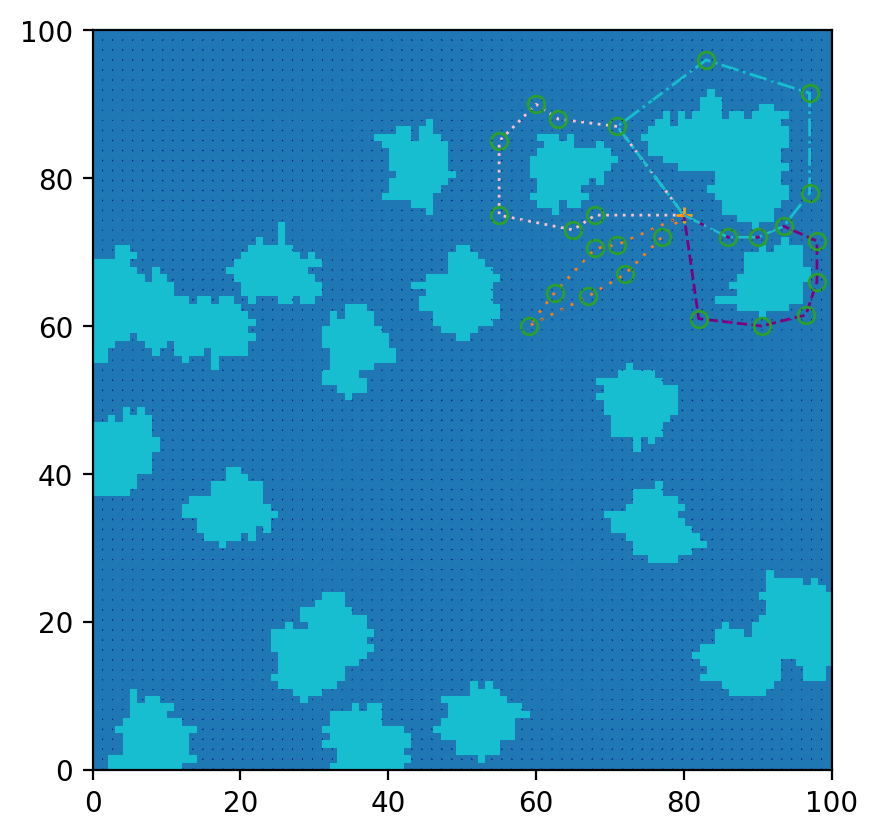

In [5]:
fig, ax = plt.subplots(1,1,dpi=200)
plot_grid(connectivity_grid, ax, cmap='tab10_r')
plot_pts(root_node, ax, '+', color='orange')
plot_pts(pathA, ax, ls=(0, (1,2)), color='pink', lw=1)
plot_pts(pathB, ax, ls='dashed', color='purple', lw=1)
plot_pts(pathC, ax, ls='dashdot', color='tab:cyan', lw=1)
plot_pts(pathD, ax, ls=(0, (1,3)), color='tab:orange', lw=1)
plot_pts(pois, ax, marker='o', fillstyle='none', linestyle='none',color='tab:green')
plot_vectors(wave_vectors, ax, color='navy',lw=0.3)

In [6]:
# Now let's do it with waves

class AUV():
    def __init__(self, path):
        self.max_velocity = 1.
        self.path = deepcopy(path)
        self.position = self.path[0]
        # hypothesis position
        self.h_position = deepcopy(self.position)
        self.target_id = 1

    def update(self, dt):
        # Am I at my target?
        if np.allclose(self.h_position, self.path[self.target_id]):
            # Only update target if this is not the last target
            if self.target_id < len(self.path)-1:
                # New target
                self.target_id += 1
        # Delta to target
        delta = self.path[self.target_id] - self.h_position
        # Don't exceed max velocity
        if np.linalg.norm(delta) > (self.max_velocity*dt):
            diagonal = np.linalg.norm(delta)
            theta = np.arctan2(delta[1], delta[0])
            delta[0] = diagonal*np.cos(theta)
            delta[1] = diagonal*np.sin(theta)
        # Update position
        self.position += delta*dt
        self.h_position += delta*dt

dt = 0.1
auv = AUV(pathA)
actual_path = [deepcopy(auv.position)]
h_path = [deepcopy(auv.h_position)]
for i in range(1000):
    auv.update(dt)
    auv.position += np.array([ wave_x(auv.position[0])*dt, wave_y(auv.position[1])*dt ])
    actual_path.append(deepcopy(auv.position))
    h_path.append(deepcopy(auv.h_position))
actual_path = np.array(actual_path)
h_path = np.array(h_path)

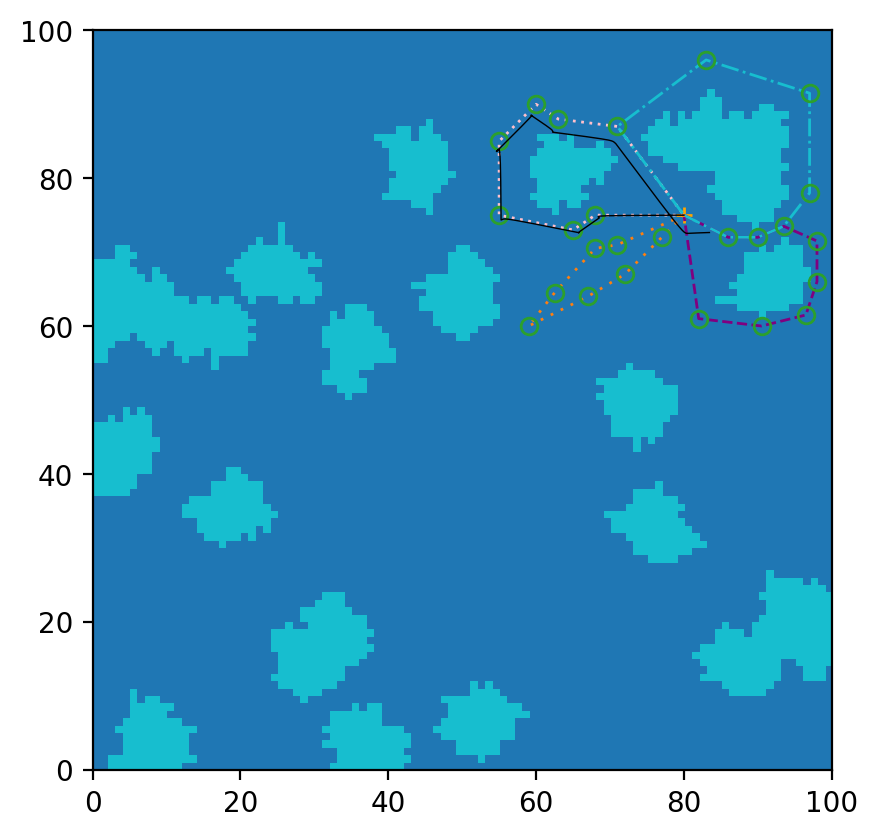

In [7]:
fig, ax = plt.subplots(1,1,dpi=200)
plot_grid(connectivity_grid, ax, cmap='tab10_r')
plot_pts(root_node, ax, '+', color='orange')
plot_pts(pathA, ax, ls=(0, (1,2)), color='pink', lw=1)
plot_pts(pathB, ax, ls='dashed', color='purple', lw=1)
plot_pts(pathC, ax, ls='dashdot', color='tab:cyan', lw=1)
plot_pts(pathD, ax, ls=(0, (1,3)), color='tab:orange', lw=1)
plot_pts(pois, ax, marker='o', fillstyle='none', linestyle='none',color='tab:green')
plot_pts(actual_path, ax, ls='solid', color='black', lw=0.5)

In [8]:
# Simulate AUVs

class AUV():
    def __init__(self, path):
        self.max_velocity = 1.
        self.path = deepcopy(path)
        self.position = self.path[0]
        # hypothesis position
        self.h_position = deepcopy(self.position)
        self.target_id = 1

    def update(self, dt):
        # Am I at my target?
        if np.allclose(self.h_position, self.path[self.target_id]):
            # Only update target if this is not the last target
            if self.target_id < len(self.path)-1:
                # New target
                self.target_id += 1
        # Delta to target
        delta = self.path[self.target_id] - self.h_position
        # Don't exceed max velocity
        if np.linalg.norm(delta) > (self.max_velocity*dt):
            diagonal = np.linalg.norm(delta)
            theta = np.arctan2(delta[1], delta[0])
            delta[0] = diagonal*np.cos(theta)
            delta[1] = diagonal*np.sin(theta)
        # Update position
        self.position += delta*dt
        self.h_position += delta*dt

dt = 0.1
paths = [pathA, pathB, pathC, pathD]
auvs = [AUV(path) for path in paths]
actual_paths = [[deepcopy(auv.position)] for auv in auvs]
h_paths = [[deepcopy(auv.h_position)] for auv in auvs]

for i in range(1000):
    for id, auv in enumerate(auvs):
        auv.update(dt)
        auv.position += np.array([ wave_x(auv.position[0])*dt, wave_y(auv.position[1])*dt ])
        actual_paths[id].append(deepcopy(auv.position))
        h_paths[id].append(deepcopy(auv.h_position))

actual_paths = np.array(actual_paths)
h_paths = np.array(h_paths)

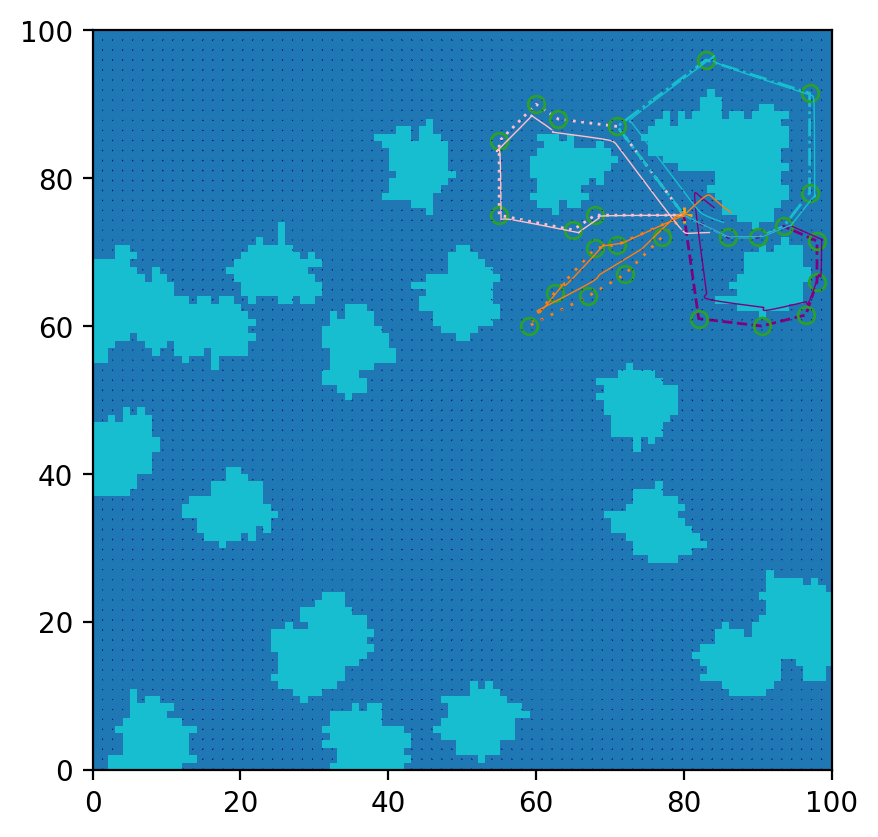

In [9]:
fig, ax = plt.subplots(1,1,dpi=200)
plot_grid(connectivity_grid, ax, cmap='tab10_r')
plot_pts(root_node, ax, '+', color='orange')
plot_pts(pathA, ax, ls=(0, (1,2)), color='pink', lw=1)
plot_pts(pathB, ax, ls='dashed', color='purple', lw=1)
plot_pts(pathC, ax, ls='dashdot', color='tab:cyan', lw=1)
plot_pts(pathD, ax, ls=(0, (1,3)), color='tab:orange', lw=1)
plot_pts(pois, ax, marker='o', fillstyle='none', linestyle='none',color='tab:green')

plot_pts(actual_paths[0], ax, ls='solid', color='pink', lw=0.5)
plot_pts(actual_paths[1], ax, ls='solid', color='purple', lw=0.5)
plot_pts(actual_paths[2], ax, ls='solid', color='tab:cyan', lw=0.5)
plot_pts(actual_paths[3], ax, ls='solid', color='tab:orange', lw=0.5)

plot_vectors(wave_vectors, ax, color='navy', lw=0.3)

In [10]:
# Let's add a ping from a surface vehicle to see if that helps with localization
class AUV():
    def __init__(self, path):
        self.max_velocity = 1.
        self.path = deepcopy(path)
        self.position = self.path[0]
        # hypothesis position
        self.h_position = deepcopy(self.position)
        self.target_id = 1

    def update(self, dt):
        print("comparison", self.h_position, self.path[self.target_id])
        # Am I at my target?
        if np.allclose(self.h_position, self.path[self.target_id]):
            # Only update target if this is not the last target
            if self.target_id < len(self.path)-1:
                # New target
                self.target_id += 1
        # Delta to target
        delta = self.path[self.target_id] - self.h_position
        print('delta: ', delta)
        # Don't exceed max velocity
        if np.linalg.norm(delta) > (self.max_velocity*dt):
            theta = np.arctan2(delta[1], delta[0])
            delta[0] = self.max_velocity*dt*np.cos(theta)
            delta[1] = self.max_velocity*dt*np.sin(theta)
        print('delta scaled: ', delta)
        # Update position
        self.position += delta
        self.h_position += delta
        print("new h_position: ", self.h_position)
        print("new position: ", self.position)
        # Am I at my target?
        if np.allclose(self.h_position, self.path[self.target_id]):
            # Only update target if this is not the last target
            if self.target_id < len(self.path)-1:
                # New target
                self.target_id += 1

    def ping(self):
        # Spoof it
        self.h_position = deepcopy(self.position)

        # Commented out more complicated code
        # If I want to do this properly, I need a Bayesian/Kalman/Particle Filter
        # print("prior: ", self.h_position)
        # # I know the position of the ping and my distance from the ping
        # delta = self.h_position - position
        # # Scale delta by distance
        # theta = np.arctan2(delta[1], delta[0])
        # delta[0] = distance*np.cos(theta)
        # delta[1] = distance*np.sin(theta)
        # # Update hypothesis of position
        # self.h_position = position + delta
        # print("new:", self.h_position)

dt = 0.1
paths = [pathA]
auvs = [AUV(path) for path in paths]
actual_paths = [[deepcopy(auv.position)] for auv in auvs]
h_paths = [[deepcopy(auv.h_position)] for auv in auvs]
wave_paths = [[[0.,0.]] for auv in auvs]

for i in range(500):
    for id, auv in enumerate(auvs):
        # Ping all the auvs from the starting point
        # Wave moves auv
        auv.position += np.array([ wave_x(auv.position[0])*dt, wave_y(auv.position[1])*dt ])
        print("wave: ", [ wave_x(auv.position[0])*dt, wave_y(auv.position[1])*dt ])
        # auv acts based on hypothesis position
        auv.update(dt)
        # Ping gives auv better hypothesis
        # auv.ping(auv.position, 0.0)
        # auv.ping(root_node[0], np.linalg.norm(root_node-auv.position))
        auv.ping()
        actual_paths[id].append(deepcopy(auv.position))
        h_paths[id].append(deepcopy(auv.h_position))
        wave_paths[id].append([ wave_x(auv.position[0])*dt, wave_y(auv.position[1])*dt ])

actual_paths = np.array(actual_paths)
h_paths = np.array(h_paths)
wave_paths = np.array(wave_paths)

wave:  [0.00989213810781935, -0.0042740862190283275]
comparison [80. 75.] [68. 75.]
delta:  [-12.   0.]
delta scaled:  [-1.0000000e-01  1.2246468e-17]
new h_position:  [79.9 75. ]
new position:  [79.90989358 74.99571817]
wave:  [0.00990493328335354, -0.004266356609987662]
comparison [79.90989358 74.99571817] [68. 75.]
delta:  [-1.19098936e+01  4.28182669e-03]
delta scaled:  [-9.99999935e-02  3.59518445e-05]
new h_position:  [79.80989359 74.99575413]
new position:  [79.81979988 74.99148004]
wave:  [0.00991692296122834, -0.0042587028105310655]
comparison [79.81979988 74.99148004] [68. 75.]
delta:  [-1.18197999e+01  8.51996107e-03]
delta scaled:  [-9.99999740e-02  7.20820906e-05]
new h_position:  [79.71979991 74.99155212]
new position:  [79.7297181 74.9872857]
wave:  [0.009928106582454816, -0.0042511251055626946]
comparison [79.7297181 74.9872857] [68. 75.]
delta:  [-11.7297181   0.0127143]
delta scaled:  [-0.09999994  0.00010839]
new h_position:  [79.62971816 74.98739409]
new position:  

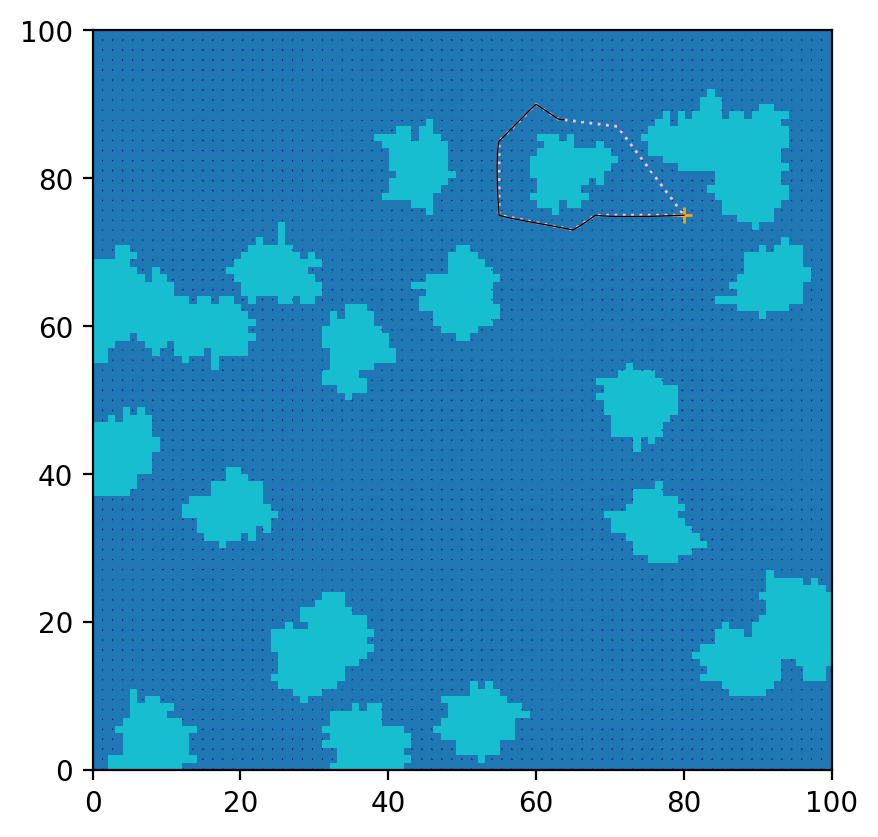

In [11]:
fig, ax = plt.subplots(1,1,dpi=200)
plot_grid(connectivity_grid, ax, cmap='tab10_r')
plot_pts(root_node, ax, '+', color='orange')

plot_pts(pathA, ax, ls=(0, (1,2)), color='pink', lw=1)
# plot_pts(pathB, ax, ls='dashed', color='purple', lw=1)
# plot_pts(pathC, ax, ls='dashdot', color='tab:cyan', lw=1)
# plot_pts(pathD, ax, ls=(0, (1,3)), color='tab:orange', lw=1)
# plot_pts(pois, ax, marker='o', fillstyle='none', linestyle='none',color='tab:green')

plot_pts(actual_paths[0], ax, ls='solid', color='pink', lw=0.5)
# plot_pts(actual_paths[1], ax, ls='solid', color='purple', lw=0.5)
# plot_pts(actual_paths[2], ax, ls='solid', color='tab:cyan', lw=0.5)
# plot_pts(actual_paths[3], ax, ls='solid', color='tab:orange', lw=0.5)

plot_pts(h_paths[0], ax, ls='solid', color='black', lw=0.5)

plot_vectors(wave_vectors, ax, color='navy', lw=0.3)

In [12]:
def generate_steps(positionA, positionB, step_size):
    vector = positionB - positionA
    theta = np.arctan2(vector[1], vector[0])
    x_step = step_size * np.cos(theta)
    y_step = step_size * np.sin(theta)
    pts = [deepcopy(positionA)]
    while step_size < np.linalg.norm(pts[-1]-positionB):
        pts.append( np.array([ pts[-1][0]+x_step, pts[-1][1]+y_step ]) )
    if not np.allclose(pts[-1], positionB):
        pts.append(deepcopy(positionB))
    return pts

def determine_collision(pt, connectivity_grid):
    # Map pt to grid
    coord = pt.astype(int)
    if connectivity_grid[coord[0], coord[1]] == 0:
        # Yes collision
        return True
    else:
        # No collision
        return False

def determine_collisions(pts, connectivity_grid):
    for pt in pts:
        # Map pt to grid
        if determine_collision(pt, connectivity_grid):
            return True
    return False

# Make it so ping only works with line of sight
def line_of_sight(positionA, positionB, connectivity_grid, step_size):
    pts = generate_steps(positionA, positionB, step_size)
    # No collisions means we have line of sight
    if not determine_collisions(pts, connectivity_grid):
        return True
    else:
        return False

# Let's add a ping from a surface vehicle to see if that helps with localization
class AUV():
    def __init__(self, path):
        self.max_velocity = 1.
        self.path = deepcopy(path)
        self.position = self.path[0]
        # hypothesis position
        self.h_position = deepcopy(self.position)
        self.target_id = 1

    def update(self, dt):
        # Am I at my target?
        if np.allclose(self.h_position, self.path[self.target_id]):
            # Only update target if this is not the last target
            if self.target_id < len(self.path)-1:
                # New target
                self.target_id += 1
        # Delta to target
        delta = self.path[self.target_id] - self.h_position
        # Don't exceed max velocity
        if np.linalg.norm(delta) > (self.max_velocity*dt):
            theta = np.arctan2(delta[1], delta[0])
            delta[0] = self.max_velocity*dt*np.cos(theta)
            delta[1] = self.max_velocity*dt*np.sin(theta)
        # Update position
        self.position += delta
        self.h_position += delta
        # Am I at my target?
        if np.allclose(self.h_position, self.path[self.target_id]):
            # Only update target if this is not the last target
            if self.target_id < len(self.path)-1:
                # New target
                self.target_id += 1

    def ping(self, connectivity_grid, ping_position, step_size):
        # Only works if we have line of sight now
        if line_of_sight(self.position, ping_position, connectivity_grid, step_size):
            self.h_position = deepcopy(self.position)
        # Otherwise doesn't do anything

dt = 0.1
paths = [pathA, pathB, pathC, pathD]
auvs = [AUV(path) for path in paths]
actual_paths = [[deepcopy(auv.position)] for auv in auvs]
h_paths = [[deepcopy(auv.h_position)] for auv in auvs]
wave_paths = [[[0.,0.]] for auv in auvs]

for i in range(1000):
    for id, auv in enumerate(auvs):
        # Ping all the auvs from the starting point
        # Wave moves auv
        auv.position += np.array([ wave_x(auv.position[0])*dt, wave_y(auv.position[1])*dt ])
        # print("wave: ", [ wave_x(auv.position[0])*dt, wave_y(auv.position[1])*dt ])
        # auv acts based on hypothesis position
        auv.update(dt)
        # Ping gives auv better hypothesis
        # auv.ping(auv.position, 0.0)
        # auv.ping(root_node[0], np.linalg.norm(root_node-auv.position))
        auv.ping(connectivity_grid, root_node[0], step_size=0.1)
        actual_paths[id].append(deepcopy(auv.position))
        h_paths[id].append(deepcopy(auv.h_position))
        wave_paths[id].append([ wave_x(auv.position[0])*dt, wave_y(auv.position[1])*dt ])

actual_paths = np.array(actual_paths)
h_paths = np.array(h_paths)
wave_paths = np.array(wave_paths)

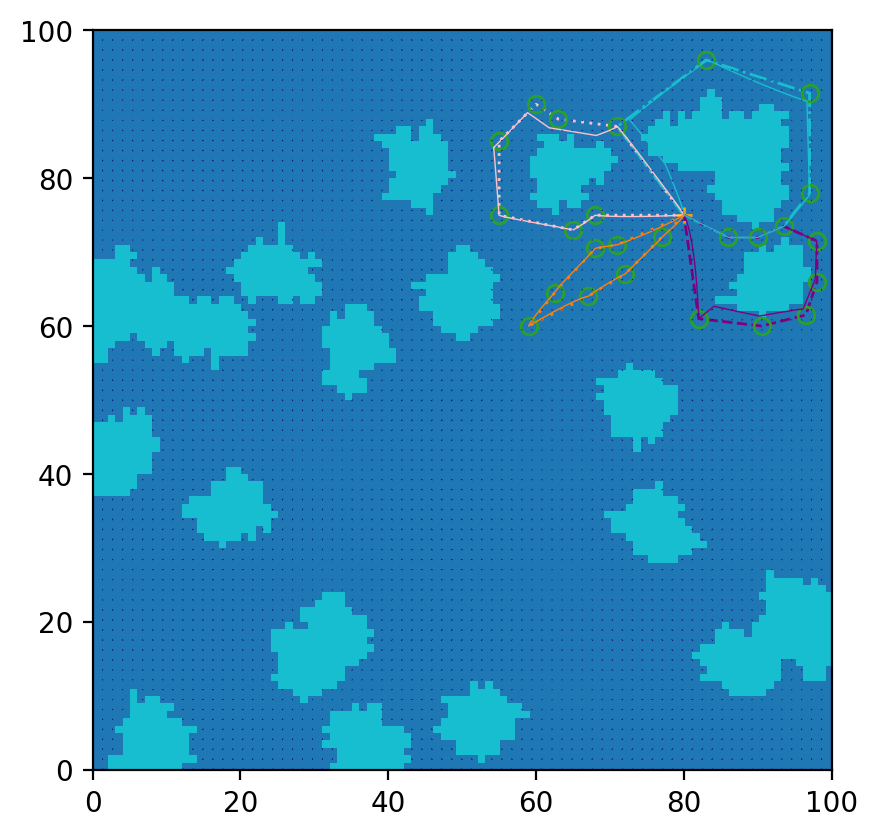

In [13]:
fig, ax = plt.subplots(1,1,dpi=200)
plot_grid(connectivity_grid, ax, cmap='tab10_r')
plot_pts(root_node, ax, '+', color='orange')

plot_pts(pathA, ax, ls=(0, (1,2)), color='pink', lw=1)
plot_pts(pathB, ax, ls='dashed', color='purple', lw=1)
plot_pts(pathC, ax, ls='dashdot', color='tab:cyan', lw=1)
plot_pts(pathD, ax, ls=(0, (1,3)), color='tab:orange', lw=1)
plot_pts(pois, ax, marker='o', fillstyle='none', linestyle='none',color='tab:green')

plot_pts(actual_paths[0], ax, ls='solid', color='pink', lw=0.5)
plot_pts(actual_paths[1], ax, ls='solid', color='purple', lw=0.5)
plot_pts(actual_paths[2], ax, ls='solid', color='tab:cyan', lw=0.5)
plot_pts(actual_paths[3], ax, ls='solid', color='tab:orange', lw=0.5)

# plot_pts(h_paths[0], ax, ls='solid', color='black', lw=0.5)

plot_vectors(wave_vectors, ax, color='navy', lw=0.3)

In [23]:
# Make it so the AUV can crash

def generate_steps(positionA, positionB, step_size):
    vector = positionB - positionA
    theta = np.arctan2(vector[1], vector[0])
    x_step = step_size * np.cos(theta)
    y_step = step_size * np.sin(theta)
    pts = [deepcopy(positionA)]
    while step_size < np.linalg.norm(pts[-1]-positionB):
        pts.append( np.array([ pts[-1][0]+x_step, pts[-1][1]+y_step ]) )
    if not np.allclose(pts[-1], positionB):
        pts.append(deepcopy(positionB))
    return pts

def determine_collision(pt, connectivity_grid):
    # Map pt to grid
    coord = pt.astype(int)
    if connectivity_grid[coord[0], coord[1]] == 0:
        # Yes collision
        return True
    else:
        # No collision
        return False

def determine_collisions(pts, connectivity_grid):
    for pt in pts:
        # Map pt to grid
        if determine_collision(pt, connectivity_grid):
            return True
    return False

# Make it so ping only works with line of sight
def line_of_sight(positionA, positionB, connectivity_grid, step_size):
    pts = generate_steps(positionA, positionB, step_size)
    # No collisions means we have line of sight
    if not determine_collisions(pts, connectivity_grid):
        return True
    else:
        return False

# Let's add a ping from a surface vehicle to see if that helps with localization
class AUV():
    def __init__(self, path):
        self.max_velocity = 1.
        self.path = deepcopy(path)
        self.position = self.path[0]
        # hypothesis position
        self.h_position = deepcopy(self.position)
        self.target_id = 1
        self.crashed = False

    def update(self, dt):
        # Am I at my target?
        if np.allclose(self.h_position, self.path[self.target_id]):
            # Only update target if this is not the last target
            if self.target_id < len(self.path)-1:
                # New target
                self.target_id += 1
        # Delta to target
        delta = self.path[self.target_id] - self.h_position
        # Don't exceed max velocity
        if np.linalg.norm(delta) > (self.max_velocity*dt):
            theta = np.arctan2(delta[1], delta[0])
            delta[0] = self.max_velocity*dt*np.cos(theta)
            delta[1] = self.max_velocity*dt*np.sin(theta)
        # Update position
        self.position += delta
        self.h_position += delta
        # Am I at my target?
        if np.allclose(self.h_position, self.path[self.target_id]):
            # Only update target if this is not the last target
            if self.target_id < len(self.path)-1:
                # New target
                self.target_id += 1

    def ping(self, connectivity_grid, ping_position, step_size):
        # Only works if we have line of sight now
        if line_of_sight(self.position, ping_position, connectivity_grid, step_size):
            self.h_position = deepcopy(self.position)
        # Otherwise doesn't do anything

dt = 0.1
paths = [pathA, pathB, pathC, pathD]
auvs = [AUV(path) for path in paths]
actual_paths = [[deepcopy(auv.position)] for auv in auvs]
h_paths = [[deepcopy(auv.h_position)] for auv in auvs]
wave_paths = [[[0.,0.]] for auv in auvs]

for i in range(1000):
    for id, auv in enumerate(auvs):
        # Ping all the auvs from the starting point
        # Wave moves auv
        if not auv.crashed:
            auv.position += np.array([ wave_x(auv.position[0])*dt, wave_y(auv.position[1])*dt ])
        if determine_collision(auv.position, connectivity_grid):
            auv.crashed = True
        # auv acts based on hypothesis position
        if not auv.crashed:
            auv.update(dt)
        if determine_collision(auv.position, connectivity_grid):
            auv.crashed = True
        # Ping gives auv better hypothesis
        auv.ping(connectivity_grid, root_node[0], step_size=0.1)
        actual_paths[id].append(deepcopy(auv.position))
        h_paths[id].append(deepcopy(auv.h_position))
        wave_paths[id].append([ wave_x(auv.position[0])*dt, wave_y(auv.position[1])*dt ])

actual_paths = np.array(actual_paths)
h_paths = np.array(h_paths)
wave_paths = np.array(wave_paths)

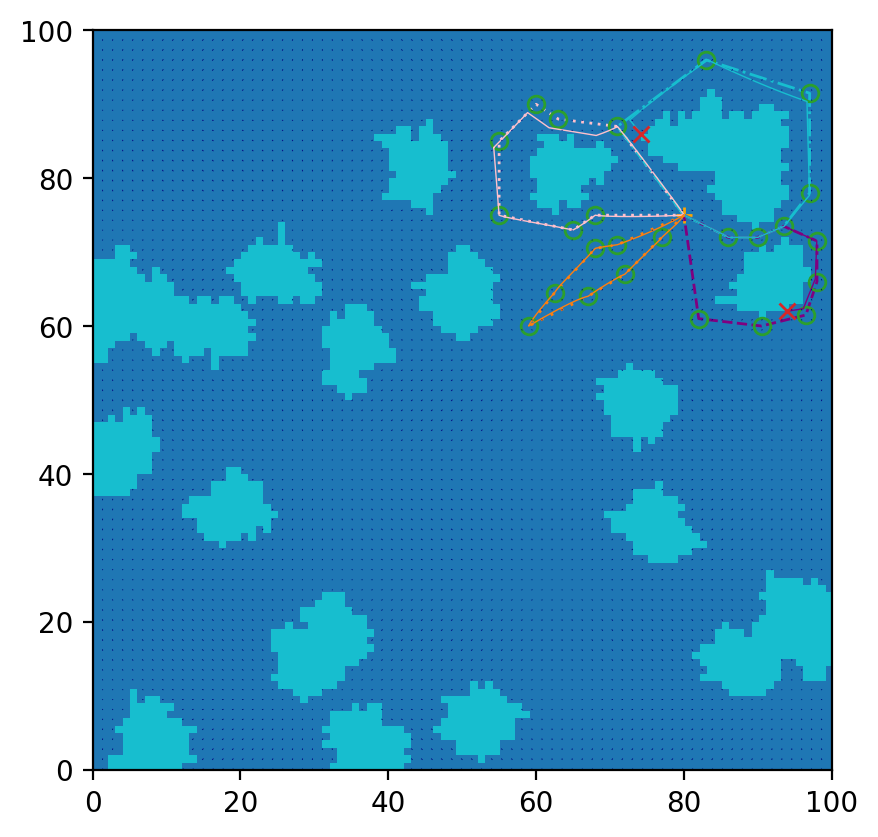

In [25]:
fig, ax = plt.subplots(1,1,dpi=200)
plot_grid(connectivity_grid, ax, cmap='tab10_r')
plot_pts(root_node, ax, '+', color='orange')

plot_pts(pathA, ax, ls=(0, (1,2)), color='pink', lw=1)
plot_pts(pathB, ax, ls='dashed', color='purple', lw=1)
plot_pts(pathC, ax, ls='dashdot', color='tab:cyan', lw=1)
plot_pts(pathD, ax, ls=(0, (1,3)), color='tab:orange', lw=1)
plot_pts(pois, ax, marker='o', fillstyle='none', linestyle='none',color='tab:green')

plot_pts(actual_paths[0], ax, ls='solid', color='pink', lw=0.5)
plot_pts(actual_paths[1], ax, ls='solid', color='purple', lw=0.5)
plot_pts(actual_paths[2], ax, ls='solid', color='tab:cyan', lw=0.5)
plot_pts(actual_paths[3], ax, ls='solid', color='tab:orange', lw=0.5)

for auv in auvs:
    if auv.crashed:
        plot_pts(np.array([auv.position]), ax, 'x', color='tab:red')
# plot_pts(h_paths[0], ax, ls='solid', color='black', lw=0.5)

plot_vectors(wave_vectors, ax, color='navy', lw=0.3)

In [66]:
# For the reward function I need to flesh out how POIs work here
class POI():
    def __init__(self, position, value, observation_radius):
        self.position = position
        self.value = value
        self.observation_radius = observation_radius

class AUVInfo():
    def __init__(self, auv_ind, distance, position):
        self.auv_ind = auv_ind
        self.distance = distance
        self.position = position

def get_nearest_auvs(auvs, auv_paths, pois, connectivity_grid, step_size):
     # Initialize storage for which auv was closest to each poi
    nearest_auvs = [AUVInfo(auv_ind=None, distance=np.inf, position=None) for _ in pois]

    # Go through paths and determine which auv was closest to each poi
    for auv_path in auv_paths:
        for auv_ind, (auv_position, auv) in enumerate(zip(auv_path, auvs)):
            # This auv only counts if it didn't crash
            if not auv.crashed:
                for poi_ind, poi in enumerate(pois):
                    # Check line of sight
                    if line_of_sight(auv_position, poi.position, connectivity_grid, step_size):
                        distance = np.linalg.norm(auv_position - poi.position)
                        if distance < nearest_auvs[poi_ind].distance:
                            nearest_auvs[poi_ind] = AUVInfo(auv_ind=auv_ind, distance = distance, position = deepcopy(auv_position))

    return nearest_auvs

# I need a reward function
def calculate_reward(auvs, auv_paths, pois):
    # We need to go through the paths and determine which auv was closest to each poi
    nearest_auvs = get_nearest_auvs(auvs, auv_paths, pois)

    # Now let's compute the value of the observations
    reward = 0
    for poi, auv_info in zip(pois, nearest_auvs):
        # Make sure this poi was observed
        if auv_info.auv_ind is not None:
            reward += 1./auv_info.distance * poi.value
    return reward


In [67]:
# Let's see if we're getting the nearest auv properly
pois_full = [POI(position, value=1., observation_radius = 3.) for position in pois]
nearest_auvs = get_nearest_auvs(auvs, actual_paths, pois_full, connectivity_grid, step_size=0.1)
for auv_info in nearest_auvs:
    print(auv_info.auv_ind, auv_info.distance)

3 6.376072474492671
None inf
None inf
None inf
None inf
None inf
3 13.957399486180337
None inf
None inf
None inf
3 14.849689659137004
3 11.729724990698347
3 14.863172600577249
3 24.729721368340506
None inf
None inf
None inf
3 9.570922094002018
3 12.539982596872212
3 20.129598054227223
3 25.530002803568607
3 16.756110732410615
3 11.046168761378658
3 3.975590789889228
3 10.112897543129906


In [81]:
def get_nearest_auvs(auvs, auv_paths, pois, connectivity_grid, step_size):
     # Initialize storage for which auv was closest to each poi
    nearest_auvs = [AUVInfo(auv_ind=None, distance=np.inf, position=None) for _ in pois]

    # Go through paths and determine which auv was closest to each poi
    print("auv_paths: ", auv_paths.shape)
    for auv_path, auv in zip(auv_paths, auvs):
        print("auv_path: ", auv_path.shape)
        for auv_ind, auv_position in enumerate(auv_path):
            print("auv_position: ", auv_position.shape, auv_position)
            # This auv only counts if it didn't crash
            if not auv.crashed:
                for poi_ind, poi in enumerate(pois):
                    # Check line of sight
                    if line_of_sight(auv_position, poi.position, connectivity_grid, step_size):
                        distance = np.linalg.norm(auv_position - poi.position)
                        if distance < nearest_auvs[poi_ind].distance:
                            nearest_auvs[poi_ind] = AUVInfo(auv_ind=auv_ind, distance = distance, position = deepcopy(auv_position))

    return nearest_auvs

print("With AUV 3")
nearest_auvs = get_nearest_auvs(auvs=[auvs[3]], auv_paths = np.array([actual_paths[3]]), pois=pois_full, connectivity_grid=connectivity_grid, step_size=0.1)
# for auv_info in nearest_auvs:
#     print(auv_info.auv_ind, auv_info.distance, auv_info.position)
# print("With AUV 0")
# nearest_auvs = get_nearest_auvs(auvs=[auvs[0]], auv_paths = np.array([actual_paths[0]]), pois=pois_full, connectivity_grid=connectivity_grid, step_size=0.1)
# for auv_info in nearest_auvs:
#     print(auv_info.auv_ind, auv_info.distance, auv_info.position)

With AUV 3
auv_paths:  (1, 1001, 2)
auv_path:  (1001, 2)
auv_position:  (2,) [80. 75.]
auv_position:  (2,) [79.91851243 74.95510433]
auv_position:  (2,) [79.8370034  74.91036427]
auv_position:  (2,) [79.75547232 74.8657799 ]
auv_position:  (2,) [79.67391859 74.82135129]
auv_position:  (2,) [79.59234163 74.77707849]
auv_position:  (2,) [79.51074084 74.73296154]
auv_position:  (2,) [79.42911564 74.68900045]
auv_position:  (2,) [79.34746543 74.64519524]
auv_position:  (2,) [79.26578962 74.6015459 ]
auv_position:  (2,) [79.18408763 74.55805241]
auv_position:  (2,) [79.10235887 74.51471474]
auv_position:  (2,) [79.02060275 74.47153284]
auv_position:  (2,) [78.93881868 74.42850666]
auv_position:  (2,) [78.85700609 74.38563613]
auv_position:  (2,) [78.77516438 74.34292115]
auv_position:  (2,) [78.69329298 74.30036163]
auv_position:  (2,) [78.6113913  74.25795746]
auv_position:  (2,) [78.52945877 74.21570852]
auv_position:  (2,) [78.44749479 74.17361466]
auv_position:  (2,) [78.3654988  74.131

In [72]:
# I see the issue
# Nearest auv is only counted at the first step. Does not actually iterate across time... what am I iterating over then?
for actual_path in actual_paths:
    for position in actual_path:
        print(position)

[80. 75.]
[79.90989358 74.99571817]
[79.81979988 74.99148004]
[79.7297181 74.9872857]
[79.63964745 74.98313526]
[79.54958713 74.97902883]
[79.45953636 74.97496652]
[79.36949433 74.97094844]
[79.27946026 74.96697471]
[79.18943335 74.96304546]
[79.0994128 74.9591608]
[79.00939783 74.95532087]
[78.91938763 74.95152579]
[78.82938141 74.94777569]
[78.73937838 74.94407073]
[78.64937774 74.94041103]
[78.55937871 74.93679675]
[78.46938048 74.93322804]
[78.37938227 74.92970504]
[78.28938327 74.92622793]
[78.19938271 74.92279685]
[78.10937978 74.91941198]
[78.01937369 74.91607349]
[77.92936366 74.91278156]
[77.83934889 74.90953637]
[77.7493286  74.90633811]
[77.65930198 74.90318696]
[77.56926826 74.90008313]
[77.47922665 74.89702682]
[77.38917636 74.89401824]
[77.29911661 74.89105761]
[77.2090466  74.88814514]
[77.11896556 74.88528106]
[77.0288727  74.88246561]
[76.93876724 74.87969903]
[76.8486484  74.87698156]
[76.7585154  74.87431347]
[76.66836747 74.871695  ]
[76.57820381 74.86912645]
[76.48

In [58]:
# 0 6.708203932499369
# None inf
# None inf
# None inf
# None inf
# None inf
# 0 14.142135623730951
# None inf
# None inf
# None inf
# 0 15.0
# 0 12.0
# 0 15.132745950421556
# None inf
# None inf
# None inf
# None inf
# 0 9.848857801796104
# 0 12.816005617976296
# 0 20.40833163195855
# 0 25.80697580112788
# 0 17.029386365926403
# 0 11.313708498984761
# 0 4.242640687119285
# 0 10.44030650891055

In [57]:
# 0 6.708203932499369
# None inf
# None inf
# None inf
# None inf
# None inf
# 0 14.142135623730951
# None inf
# None inf
# None inf
# 0 15.0
# 0 12.0
# 0 15.132745950421556
# None inf
# None inf
# None inf
# None inf
# 0 9.848857801796104
# 0 12.816005617976296
# 0 20.40833163195855
# 0 25.80697580112788
# 0 17.029386365926403
# 0 11.313708498984761
# 0 4.242640687119285
# 0 10.44030650891055